<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/3_Data_balacing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

org = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/chosen_dataset_xgboost.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [33]:
org

,date,% Silica Feed,Amina Flow,Flotation Column 01 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 02 Level,Flotation Column 03 Level,% Iron Concentrate,% Silica Concentrate,Purity
0,2017-03-10 01:00:00,16.98,578.910104,251.177960,250.175988,295.096000,446.972364,450.622040,66.91,1.31,1
1,2017-03-10 02:00:00,16.98,537.219661,249.880589,250.033317,295.096000,450.249356,450.081222,67.06,1.11,1
2,2017-03-10 03:00:00,16.98,591.906744,250.161328,250.046350,295.096000,450.868711,450.901822,66.97,1.27,1
3,2017-03-10 04:00:00,16.98,593.170106,250.208772,250.120861,295.096000,491.462111,487.387206,66.75,1.36,1
4,2017-03-10 05:00:00,16.98,619.710806,249.917800,250.013500,295.096000,549.983156,549.459572,66.63,1.34,1
...,...,...,...,...,...,...,...,...,...,...,...
3417,2017-09-09 19:00:00,23.20,498.785884,301.432594,299.756449,299.929000,497.870623,409.189681,65.05,1.65,1
3418,2017-09-09 20:00:00,23.20,510.780566,300.181000,299.593867,299.526313,498.402434,392.437663,64.83,1.71,1
3419,2017-09-09 21:00:00,23.20,519.289535,299.419465,299.995958,299.767268,500.891915,459.091225,64.29,1.80,1
3420,2017-09-09 22:00:00,23.20,493.451375,299.738536,299.809750,299.995732,494.662857,830.694840,64.25,1.96,1


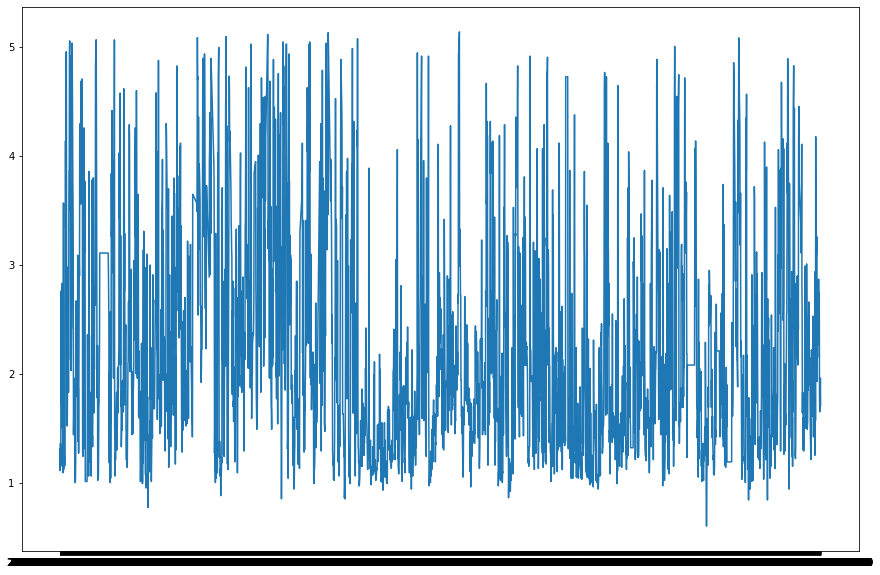

In [34]:
plt.figure(figsize = (15, 10))
plt.plot(org["date"], org["% Silica Concentrate"])
plt.show();

Purity
0     771
1    2651
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  import sys


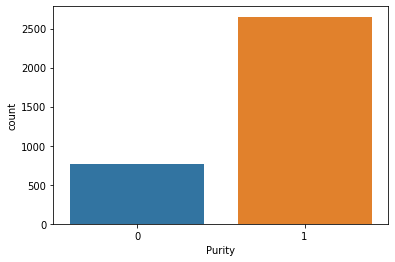

In [35]:
df = org

df.dropna(inplace = True)

df["date"] = pd.to_datetime(df["date"])

df.insert(0,'new_date',pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S').astype(int))

df.drop('date', axis=1, inplace=True)

print(df.groupby(['Purity']).size())


sns.countplot(x ='Purity', data = df);

##  **Smote**

Before smote:  3422
Counter({1: 2651, 0: 771})
Counter({1: 2651, 0: 2651})
After smote :  5302


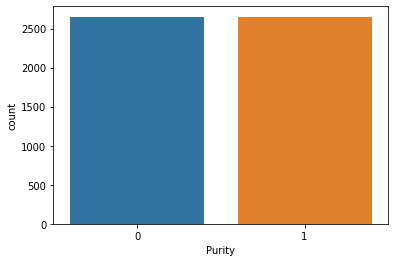

In [36]:
## Implementing smote method

from collections import Counter
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot

X = df.drop(['Purity'], axis=1)
y = df['Purity']

print('Before smote: ',len(X))

counter = Counter(y)
print(counter)

oversample = SMOTE()
X_res, y_res = oversample.fit_resample(X, y)

counter = Counter(y_res)
print(counter)

print('After smote : ',len(X_res))

smote_df = pd.concat([X_res, y_res], axis=1)
sns.countplot(x ='Purity', data = smote_df);

##  **Smote & TomerLinks**

Original dataset shape Counter({1: 2651, 0: 2651})
Resampled dataset shape Counter({0: 2651, 1: 2371})
Purity
0    2651
1    2371
dtype: int64


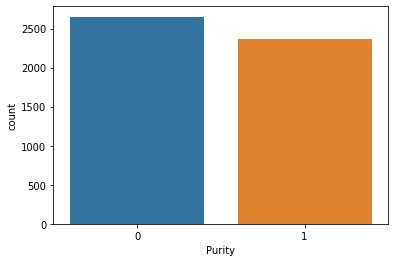

In [37]:
from imblearn.under_sampling import TomekLinks 

X = smote_df.drop(['Purity'], axis=1)
y = smote_df['Purity']

print('Original dataset shape %s' % Counter(y))

tl = TomekLinks()
X_res, y_res = tl.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

smote_tl_df = pd.concat([X_res, y_res], axis=1)
print(smote_tl_df.groupby(['Purity']).size())

sns.countplot(x ='Purity', data = smote_tl_df);

##  **Smote & ENN** 

Original dataset shape Counter({1: 2651, 0: 2651})
Resampled dataset shape Counter({0: 2651, 1: 1673})
Purity
0    2651
1    1673
dtype: int64


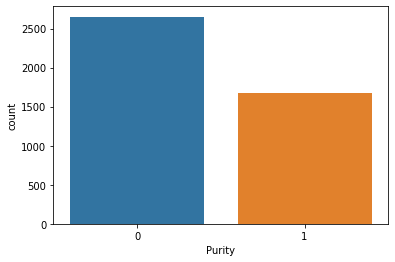

In [38]:
from imblearn.under_sampling import EditedNearestNeighbours 

X = smote_df.drop(['Purity'], axis=1)
y = smote_df['Purity']

print('Original dataset shape %s' % Counter(y))

#n_neighbors = 3
enn = EditedNearestNeighbours()
X_res, y_res = enn.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

smote_enn_df = pd.concat([X_res, y_res], axis=1)
print(smote_enn_df.groupby(['Purity']).size())

sns.countplot(x ='Purity', data = smote_enn_df);

##  **Smote-SVM**

Original dataset shape Counter({1: 2651, 0: 771})
Resampled dataset shape Counter({1: 2651, 0: 2651})
Purity
0    2651
1    2651
dtype: int64


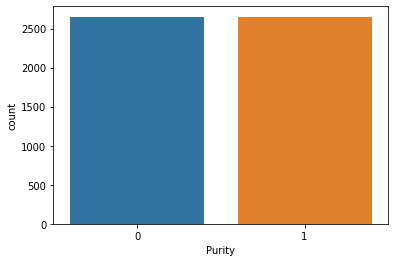

In [39]:
#Variant of SMOTE algorithm which use an SVM algorithm to detect sample to use for generating new synthetic samples.

from collections import Counter
from imblearn.over_sampling import SVMSMOTE 

X = df.drop(['Purity'], axis=1)
y = df['Purity']

print('Original dataset shape %s' % Counter(y))

sm = SVMSMOTE()
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

smote_svm_df = pd.concat([X_res, y_res], axis=1)
print(smote_svm_df.groupby(['Purity']).size())

sns.countplot(x ='Purity', data = smote_svm_df);

##  **Smote-SVM & TomerLinks**

Original dataset shape Counter({1: 2651, 0: 2651})
Resampled dataset shape Counter({0: 2651, 1: 2443})
Purity
0    2651
1    2443
dtype: int64


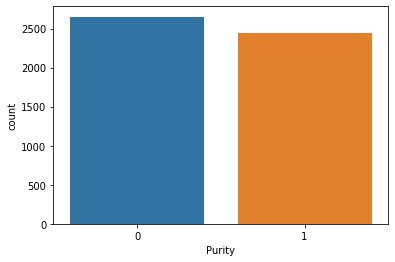

In [40]:
from imblearn.under_sampling import TomekLinks 

X = smote_svm_df.drop(['Purity'], axis=1)
y = smote_svm_df['Purity']

print('Original dataset shape %s' % Counter(y))

tl = TomekLinks()
X_res, y_res = tl.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

smote_svm_tl_df = pd.concat([X_res, y_res], axis=1)
print(smote_svm_tl_df.groupby(['Purity']).size())

sns.countplot(x ='Purity', data = smote_svm_tl_df);

##  **Smote-SVM & ENN**

Original dataset shape Counter({1: 2651, 0: 2651})
Resampled dataset shape Counter({0: 2651, 1: 1827})
Purity
0    2651
1    1827
dtype: int64


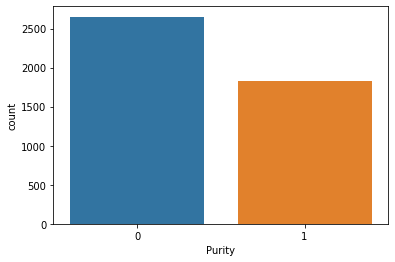

In [41]:
from imblearn.under_sampling import EditedNearestNeighbours 

X = smote_svm_df.drop(['Purity'], axis=1)
y = smote_svm_df['Purity']

print('Original dataset shape %s' % Counter(y))

#n_neighbors = 3
enn = EditedNearestNeighbours()
X_res, y_res = enn.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

smote_svm_enn_df = pd.concat([X_res, y_res], axis=1)
print(smote_svm_enn_df.groupby(['Purity']).size())

sns.countplot(x ='Purity', data = smote_svm_enn_df);

In [42]:
all_dfs = [df, smote_tl_df, smote_enn_df, smote_svm_tl_df, smote_svm_enn_df]

## KNN classification

Purity
0     771
1    2651
dtype: int64
1 97.07943925233646
_______________________________________________
Purity
0    2651
1    2371
dtype: int64
2 98.56687898089172
_______________________________________________
Purity
0    2651
1    1673
dtype: int64
3 98.70490286771508
_______________________________________________
Purity
0    2651
1    2443
dtype: int64
4 98.66562009419152
_______________________________________________
Purity
0    2651
1    1827
dtype: int64
5 98.92857142857143
_______________________________________________
{'dataset': 5, 'accuracy': 98.92857142857143, 'best_params': ['manhattan', 3, 'distance']}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       652
           1       1.00      0.98      0.99       468

    accuracy                           0.99      1120
   macro avg       0.99      0.99      0.99      1120
weighted avg       0.99      0.99      0.99      1120



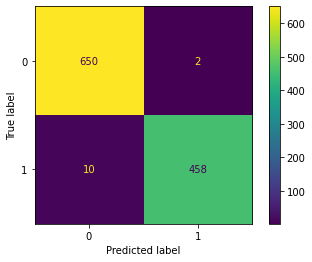

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

#initialisation
best_params = 0
model = 0
accuracy = 0
i = 0
max = {'dataset': i, 'accuracy': accuracy, 'best_params': best_params}

for df in all_dfs:
  print(df.groupby(['Purity']).size())
  i = i + 1
  X = df.drop(['Purity'], axis=1)
  y = df['Purity']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

  mms = MinMaxScaler()
  X_train = mms.fit_transform(X_train)
  X_test = mms.transform(X_test)

  grid_params = {
      'n_neighbors' : [3,5,11,19], # Always odd numbers to avaid ties
      'weights': ['uniform', 'distance'],
      'metric': ['euclidean', 'manhattan']
  }

  grid = GridSearchCV(
      KNeighborsClassifier(),
      grid_params,
      cv = 5,
      n_jobs = -1 #use all resources
  )

  grid_results = grid.fit(X_train, y_train)
  best_params = [grid_results.best_params_['metric'],grid_results.best_params_['n_neighbors'],grid_results.best_params_['weights']]

  #KNN with the best params
  model = KNeighborsClassifier(n_neighbors=best_params[1], 
                            weights=best_params[2], 
                            metric=best_params[0], 
                            n_jobs=-1)
  model.fit(X_train, y_train)
  y_test_hat=model.predict(X_test) 
  test_accuracy=accuracy_score(y_test,y_test_hat)*100
  if accuracy  < test_accuracy:
    accuracy = test_accuracy
    max = { 'dataset': i, 'accuracy': accuracy, 'best_params': best_params }
  print(i,test_accuracy)
  print('_______________________________________________')

print(max)

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);  
y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))

0.9430786118128233


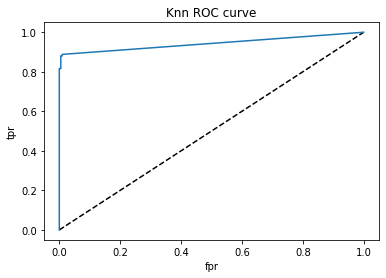

0.9600621612517989


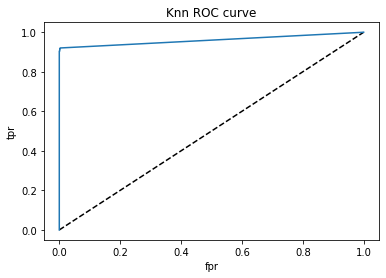

0.9855769230769231


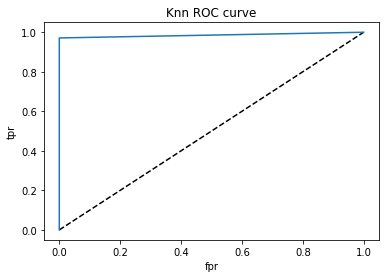

0.9906666996145103


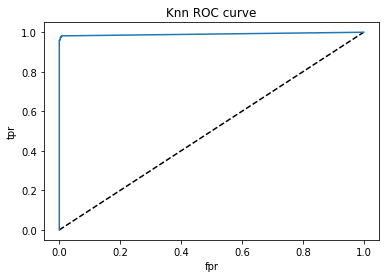

0.9958117036337895


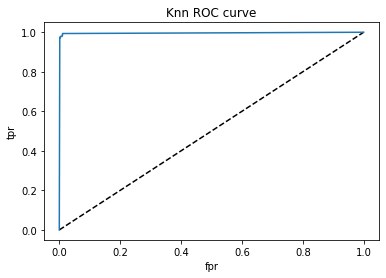

In [44]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score

for df in all_dfs:
  i = i + 1
  X = df.drop(['Purity'], axis=1)
  y = df['Purity']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

  mms = MinMaxScaler()
  X_train = mms.fit_transform(X_train)
  X_test = mms.transform(X_test)

  y_pred_proba = model.predict_proba(X_test)[:,1]
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

  print(roc_auc_score(y_test,y_pred_proba))

  plt.plot([0,1],[0,1],'k--')
  plt.plot(fpr,tpr, label='Knn')
  plt.xlabel('fpr')
  plt.ylabel('tpr')
  plt.title('Knn ROC curve')
  plt.show()


# ROC scores

Original df: 0.967810206904848 <br>
SMOTE + Tomer links df: 0.968225233568768 <br>
SMOTE + ENN df: 0.9911808669656204  <br>
SMOTESVM + Tomer links df: 0.9877097676419966 <br>
SMOTESVM + ENN df: 0.9988557398907664 ✅ <br>


In [45]:
smote_enn_df.insert(0,'dates',pd.to_datetime(smote_enn_df['new_date'], format='%Y-%m-%d %H:%M:%S'))

smote_enn_df = smote_enn_df.sort_values(by="dates")
smote_enn_df.drop('new_date', axis=1, inplace=True)

smote_enn_df

,dates,% Silica Feed,Amina Flow,Flotation Column 01 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 02 Level,Flotation Column 03 Level,% Iron Concentrate,% Silica Concentrate,Purity
2651,2017-03-10 01:00:00,16.98,578.910104,251.177960,250.175988,295.096000,446.972364,450.622040,66.91,1.31,1
2652,2017-03-10 02:00:00,16.98,537.219661,249.880589,250.033317,295.096000,450.249356,450.081222,67.06,1.11,1
2653,2017-03-10 03:00:00,16.98,591.906744,250.161328,250.046350,295.096000,450.868711,450.901822,66.97,1.27,1
2654,2017-03-10 04:00:00,16.98,593.170106,250.208772,250.120861,295.096000,491.462111,487.387206,66.75,1.36,1
2655,2017-03-10 05:00:00,16.98,619.710806,249.917800,250.013500,295.096000,549.983156,549.459572,66.63,1.34,1
...,...,...,...,...,...,...,...,...,...,...,...
4319,2017-09-09 19:00:00,23.20,498.785884,301.432594,299.756449,299.929000,497.870623,409.189681,65.05,1.65,1
4320,2017-09-09 20:00:00,23.20,510.780566,300.181000,299.593867,299.526313,498.402434,392.437663,64.83,1.71,1
4321,2017-09-09 21:00:00,23.20,519.289535,299.419465,299.995958,299.767268,500.891915,459.091225,64.29,1.80,1
4322,2017-09-09 22:00:00,23.20,493.451375,299.738536,299.809750,299.995732,494.662857,830.694840,64.25,1.96,1


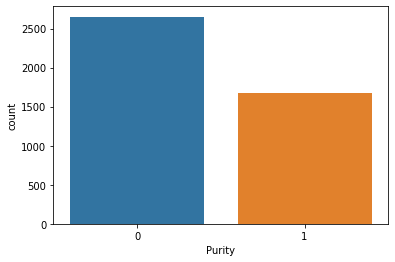

In [49]:
import seaborn as sns

sns.countplot(x ='Purity', data = smote_enn_df)
plt.show()

In [48]:
smote_enn_df.to_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/dataset_xgboost_smote_enn.csv', index=False)

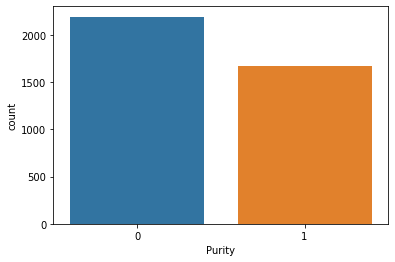

In [52]:
final = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/dataset_xgboost_smote_enn.csv', parse_dates=['dates'],  index_col='dates')

final = final.resample('10min').mean()
final.dropna(inplace = True)
final['Purity'] = final['Purity'].astype('int64')
sns.countplot(x ='Purity', data = final)
plt.show()

In [59]:
final = final.reset_index()
final.to_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final.csv', index=True)